## Load/import packages

In [2]:
import json
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import kerastuner as kt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils import class_weight

from os import listdir
from os.path import join, splitext, normpath

# Import variables and functions from my own scripts
from functions import f1, plot_history, arr_replacevalue
from load_features import (
    train_features_AW2,
    val_features_AW2,
    train_labels_AW2,
    val_labels_AW2,
    labels_reshaper,
    features_reshaper,
)

%matplotlib inline

# Limit GPU memory usage
for device in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

# Prepare data

## Reshape features, labels
The model gets more unstable and validation scores converge later with higher sequence length. Increasing sequence length does not improve the models performance.

In [9]:
# Reshape data to specified sequence length
length = 120
seq_train_features = features_reshaper(train_features_AW2, length)
seq_val_features = features_reshaper(val_features_AW2, length)

seq_train_labels = labels_reshaper(train_labels_AW2, length)
seq_val_labels = labels_reshaper(val_labels_AW2, length)

## Compute sample weights

In [10]:
def comp_sampleweights(labels):
    # Convert one-hot encoded labels back to label integers
    train_label_ints = np.argmax(labels, axis=2)

    # Compute class weights with sklearn
    class_weights = class_weight.compute_class_weight(
        "balanced", np.unique(train_label_ints), train_label_ints.flatten()
    )
    d_class_weights = dict(enumerate(class_weights))

    # Copy label integer array
    arr = train_label_ints.copy()

    # Pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample
    return arr_replacevalue(arr, d_class_weights)
    
train_samples_weights = comp_sampleweights(seq_train_labels)   

C:\Users\ion\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[0 0 0 ... 6 6 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Build HP tuner model

In [11]:
def build_model(hp):
    # Only tune the first layer of hyperparameters
    hp_unit = hp.Int("units", min_value=256, max_value=2048, step=256)

    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    model.add(layers.LSTM(hp_unit, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model

## Hyperparameter tuning

In [12]:
es = tf.keras.callbacks.EarlyStopping(
            monitor="val_f1",
            verbose=1,
            patience=3,
            mode="max",
            restore_best_weights=True,
        )

In [13]:
# Keras-tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=5,
    seed=1337,
    project_name=normpath("C:/Keras_tuner"),
    overwrite=True,
)

# Check the defined hyperparameter search space
tuner.search_space_summary()

# Do random serach for optimal hyperparameters
tuner.search(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    epochs=100,
    validation_data=(seq_val_features, seq_val_labels),
    callbacks=[es],
    verbose=2,
)

Epoch 1/100
241/241 - 27s - loss: 1.5453 - accuracy: 0.3920 - f1: 0.1262 - auc: 0.7767 - val_loss: 1.7565 - val_accuracy: 0.3386 - val_f1: 0.0292 - val_auc: 0.7253
Epoch 2/100
241/241 - 20s - loss: 1.1197 - accuracy: 0.5994 - f1: 0.3653 - auc: 0.9037 - val_loss: 1.7972 - val_accuracy: 0.3057 - val_f1: 0.0671 - val_auc: 0.7135
Epoch 3/100
241/241 - 20s - loss: 0.9450 - accuracy: 0.6814 - f1: 0.5194 - auc: 0.9356 - val_loss: 1.7177 - val_accuracy: 0.3593 - val_f1: 0.1480 - val_auc: 0.7544
Epoch 4/100
241/241 - 21s - loss: 0.8298 - accuracy: 0.7391 - f1: 0.6310 - auc: 0.9557 - val_loss: 1.6511 - val_accuracy: 0.4075 - val_f1: 0.2151 - val_auc: 0.7838
Epoch 5/100
241/241 - 21s - loss: 0.7568 - accuracy: 0.7856 - f1: 0.7082 - auc: 0.9690 - val_loss: 1.6486 - val_accuracy: 0.4153 - val_f1: 0.2633 - val_auc: 0.7869
Epoch 6/100
241/241 - 21s - loss: 0.6997 - accuracy: 0.8208 - f1: 0.7625 - auc: 0.9773 - val_loss: 1.6836 - val_accuracy: 0.3998 - val_f1: 0.2659 - val_auc: 0.7810
Epoch 7/100
241/

Epoch 1/100
241/241 - 30s - loss: 1.5302 - accuracy: 0.4333 - f1: 0.1665 - auc: 0.8006 - val_loss: 1.8097 - val_accuracy: 0.3263 - val_f1: 0.0413 - val_auc: 0.6941
Epoch 2/100
241/241 - 26s - loss: 1.0783 - accuracy: 0.6390 - f1: 0.4383 - auc: 0.9150 - val_loss: 1.7603 - val_accuracy: 0.3542 - val_f1: 0.1441 - val_auc: 0.7336
Epoch 3/100
241/241 - 26s - loss: 0.8942 - accuracy: 0.7236 - f1: 0.6048 - auc: 0.9492 - val_loss: 1.7124 - val_accuracy: 0.3979 - val_f1: 0.1865 - val_auc: 0.7561
Epoch 4/100
241/241 - 26s - loss: 0.7902 - accuracy: 0.7773 - f1: 0.6989 - auc: 0.9658 - val_loss: 1.6980 - val_accuracy: 0.4069 - val_f1: 0.2384 - val_auc: 0.7665
Epoch 5/100
241/241 - 26s - loss: 0.7114 - accuracy: 0.8212 - f1: 0.7669 - auc: 0.9773 - val_loss: 1.6928 - val_accuracy: 0.4187 - val_f1: 0.2561 - val_auc: 0.7712
Epoch 6/100
241/241 - 26s - loss: 0.6590 - accuracy: 0.8547 - f1: 0.8137 - auc: 0.9842 - val_loss: 1.6540 - val_accuracy: 0.4499 - val_f1: 0.3141 - val_auc: 0.7913
Epoch 7/100
241/

Epoch 1/100
241/241 - 18s - loss: 1.5880 - accuracy: 0.3666 - f1: 0.1160 - auc: 0.7543 - val_loss: 1.8324 - val_accuracy: 0.2346 - val_f1: 0.0114 - val_auc: 0.6808
Epoch 2/100
241/241 - 15s - loss: 1.1882 - accuracy: 0.5622 - f1: 0.2972 - auc: 0.8863 - val_loss: 1.7817 - val_accuracy: 0.3070 - val_f1: 0.0488 - val_auc: 0.7131
Epoch 3/100
241/241 - 18s - loss: 1.0140 - accuracy: 0.6484 - f1: 0.4431 - auc: 0.9227 - val_loss: 1.7377 - val_accuracy: 0.3427 - val_f1: 0.1054 - val_auc: 0.7374
Epoch 4/100
241/241 - 17s - loss: 0.9005 - accuracy: 0.7051 - f1: 0.5555 - auc: 0.9436 - val_loss: 1.7513 - val_accuracy: 0.3327 - val_f1: 0.1370 - val_auc: 0.7324
Epoch 5/100
241/241 - 17s - loss: 0.8219 - accuracy: 0.7414 - f1: 0.6335 - auc: 0.9556 - val_loss: 1.6948 - val_accuracy: 0.3787 - val_f1: 0.1968 - val_auc: 0.7635
Epoch 6/100
241/241 - 16s - loss: 0.7634 - accuracy: 0.7771 - f1: 0.6971 - auc: 0.9659 - val_loss: 1.6739 - val_accuracy: 0.3951 - val_f1: 0.2265 - val_auc: 0.7745
Epoch 7/100
241/

Epoch 1/100
241/241 - 21s - loss: 1.5733 - accuracy: 0.3876 - f1: 0.1117 - auc: 0.7616 - val_loss: 1.8415 - val_accuracy: 0.2751 - val_f1: 0.0300 - val_auc: 0.6777
Epoch 2/100
241/241 - 19s - loss: 1.1599 - accuracy: 0.5843 - f1: 0.3297 - auc: 0.8920 - val_loss: 1.7558 - val_accuracy: 0.3470 - val_f1: 0.0875 - val_auc: 0.7285
Epoch 3/100
241/241 - 18s - loss: 0.9855 - accuracy: 0.6699 - f1: 0.4841 - auc: 0.9290 - val_loss: 1.8108 - val_accuracy: 0.3117 - val_f1: 0.0893 - val_auc: 0.7098
Epoch 4/100
241/241 - 19s - loss: 0.8715 - accuracy: 0.7186 - f1: 0.5848 - auc: 0.9477 - val_loss: 1.6568 - val_accuracy: 0.4130 - val_f1: 0.2192 - val_auc: 0.7788
Epoch 5/100
241/241 - 19s - loss: 0.7894 - accuracy: 0.7687 - f1: 0.6721 - auc: 0.9630 - val_loss: 1.6504 - val_accuracy: 0.4267 - val_f1: 0.2479 - val_auc: 0.7842
Epoch 6/100
241/241 - 19s - loss: 0.7309 - accuracy: 0.8021 - f1: 0.7302 - auc: 0.9721 - val_loss: 1.6065 - val_accuracy: 0.4506 - val_f1: 0.3148 - val_auc: 0.8031
Epoch 7/100
241/

Epoch 1/100
241/241 - 17s - loss: 1.6278 - accuracy: 0.3789 - f1: 0.0761 - auc: 0.7511 - val_loss: 1.8479 - val_accuracy: 0.2706 - val_f1: 0.0053 - val_auc: 0.6694
Epoch 2/100
241/241 - 14s - loss: 1.2773 - accuracy: 0.5496 - f1: 0.2349 - auc: 0.8682 - val_loss: 1.7924 - val_accuracy: 0.3349 - val_f1: 0.0232 - val_auc: 0.7058
Epoch 3/100
241/241 - 14s - loss: 1.1065 - accuracy: 0.6315 - f1: 0.3803 - auc: 0.9092 - val_loss: 1.7270 - val_accuracy: 0.3675 - val_f1: 0.0888 - val_auc: 0.7414
Epoch 4/100
241/241 - 14s - loss: 0.9932 - accuracy: 0.6783 - f1: 0.4880 - auc: 0.9311 - val_loss: 1.7371 - val_accuracy: 0.3696 - val_f1: 0.1271 - val_auc: 0.7419
Epoch 5/100
241/241 - 15s - loss: 0.9095 - accuracy: 0.7129 - f1: 0.5680 - auc: 0.9439 - val_loss: 1.7074 - val_accuracy: 0.3920 - val_f1: 0.1798 - val_auc: 0.7589
Epoch 6/100
241/241 - 14s - loss: 0.8461 - accuracy: 0.7452 - f1: 0.6382 - auc: 0.9553 - val_loss: 1.6908 - val_accuracy: 0.4082 - val_f1: 0.2382 - val_auc: 0.7661
Epoch 7/100
241/

Epoch 1/100
241/241 - 31s - loss: 1.5110 - accuracy: 0.4410 - f1: 0.1682 - auc: 0.8049 - val_loss: 1.7749 - val_accuracy: 0.3396 - val_f1: 0.0753 - val_auc: 0.7104
Epoch 2/100
241/241 - 29s - loss: 1.0627 - accuracy: 0.6426 - f1: 0.4514 - auc: 0.9179 - val_loss: 1.7615 - val_accuracy: 0.3571 - val_f1: 0.1405 - val_auc: 0.7241
Epoch 3/100
241/241 - 31s - loss: 0.8845 - accuracy: 0.7253 - f1: 0.6103 - auc: 0.9501 - val_loss: 1.6681 - val_accuracy: 0.4076 - val_f1: 0.2151 - val_auc: 0.7769
Epoch 4/100
241/241 - 30s - loss: 0.7697 - accuracy: 0.7814 - f1: 0.7113 - auc: 0.9677 - val_loss: 1.6801 - val_accuracy: 0.4061 - val_f1: 0.2400 - val_auc: 0.7728
Epoch 5/100
241/241 - 30s - loss: 0.6967 - accuracy: 0.8231 - f1: 0.7751 - auc: 0.9783 - val_loss: 1.6618 - val_accuracy: 0.4210 - val_f1: 0.2895 - val_auc: 0.7901
Epoch 6/100
241/241 - 30s - loss: 0.6461 - accuracy: 0.8561 - f1: 0.8222 - auc: 0.9851 - val_loss: 1.6365 - val_accuracy: 0.4413 - val_f1: 0.3256 - val_auc: 0.8014
Epoch 7/100
241/

Epoch 1/100
241/241 - 17s - loss: 1.6730 - accuracy: 0.3058 - f1: 0.0486 - auc: 0.7212 - val_loss: 1.9243 - val_accuracy: 0.1777 - val_f1: 0.0013 - val_auc: 0.6258
Epoch 2/100
241/241 - 14s - loss: 1.3613 - accuracy: 0.4438 - f1: 0.1373 - auc: 0.8284 - val_loss: 1.8043 - val_accuracy: 0.3138 - val_f1: 0.0031 - val_auc: 0.7040
Epoch 3/100
241/241 - 15s - loss: 1.2066 - accuracy: 0.5266 - f1: 0.2194 - auc: 0.8752 - val_loss: 1.7248 - val_accuracy: 0.3723 - val_f1: 0.0285 - val_auc: 0.7485
Epoch 4/100
241/241 - 14s - loss: 1.0939 - accuracy: 0.5896 - f1: 0.3158 - auc: 0.9038 - val_loss: 1.7282 - val_accuracy: 0.3729 - val_f1: 0.0577 - val_auc: 0.7473
Epoch 5/100
241/241 - 14s - loss: 1.0108 - accuracy: 0.6311 - f1: 0.4018 - auc: 0.9198 - val_loss: 1.6845 - val_accuracy: 0.3948 - val_f1: 0.1258 - val_auc: 0.7692
Epoch 6/100
241/241 - 14s - loss: 0.9439 - accuracy: 0.6636 - f1: 0.4768 - auc: 0.9321 - val_loss: 1.7024 - val_accuracy: 0.3817 - val_f1: 0.1383 - val_auc: 0.7648
Epoch 7/100
241/

Epoch 1/100
241/241 - 25s - loss: 1.5164 - accuracy: 0.4362 - f1: 0.1732 - auc: 0.8063 - val_loss: 1.8638 - val_accuracy: 0.2470 - val_f1: 0.0425 - val_auc: 0.6695
Epoch 2/100
241/241 - 23s - loss: 1.0835 - accuracy: 0.6224 - f1: 0.4302 - auc: 0.9108 - val_loss: 1.6938 - val_accuracy: 0.3918 - val_f1: 0.1268 - val_auc: 0.7631
Epoch 3/100
241/241 - 23s - loss: 0.8993 - accuracy: 0.7065 - f1: 0.5810 - auc: 0.9438 - val_loss: 1.6557 - val_accuracy: 0.4114 - val_f1: 0.2138 - val_auc: 0.7833
Epoch 4/100
241/241 - 23s - loss: 0.7891 - accuracy: 0.7668 - f1: 0.6816 - auc: 0.9626 - val_loss: 1.6535 - val_accuracy: 0.4162 - val_f1: 0.2417 - val_auc: 0.7864
Epoch 5/100
241/241 - 23s - loss: 0.7149 - accuracy: 0.8100 - f1: 0.7502 - auc: 0.9743 - val_loss: 1.6166 - val_accuracy: 0.4526 - val_f1: 0.2853 - val_auc: 0.7986
Epoch 6/100
241/241 - 23s - loss: 0.6669 - accuracy: 0.8399 - f1: 0.7973 - auc: 0.9814 - val_loss: 1.6311 - val_accuracy: 0.4420 - val_f1: 0.2997 - val_auc: 0.7983
Epoch 7/100
241/

INFO:tensorflow:Oracle triggered exit


# Build optimal HP model

In [14]:
tuner.results_summary()

In [15]:
## Grab optimal hyperparameter
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'units': 1792}

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## Define optimal model

In [ ]:
LSTM = tuner.hypermodel.build(best_hps)
LSTM.summary()

# Train + Evaluate model

## Best model results

In [17]:
checkpoint_path = "data/models/cp_training_LSTM.ckpt"

import time
name = 'LSTM_opt_{}'.format(int(time.time()))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(name))

# Access tensorboard in cmd of the main repo folder with following code:
# tensorboard --logdir='logs/'

# Set callbacks for model training
csvlog = tf.keras.callbacks.CSVLogger(
    "data/models/LSTM_performance.csv", separator=",", append=False
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

history_best = LSTM.fit(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    validation_data=(seq_val_features, seq_val_labels),
    epochs=50,
    callbacks=[es, 
               cp_callback, 
               csvlog, 
               tb_callback],
    verbose=2,
)

Model: "RNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 120, 1792)         45882368  
_________________________________________________________________
layer_normalization (LayerNo (None, 120, 1792)         3584      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 120, 256)          2098176   
_________________________________________________________________
Dense_Output (Dense)         (None, 120, 7)            1799      
Total params: 47,985,927
Trainable params: 47,985,927
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
241/241 - 28s - loss: 1.5280 - accuracy: 0.4151 - f1: 0.1614 - auc: 0.7900 - val_loss: 1.7805 - val_accuracy: 0.3332 - val_f1: 0.0356 - val_auc: 0.7132

Epoch 00001: saving model to data/models\cp_training_LSTM.ckpt
Epoch 2/50
241/24

In [18]:
results = LSTM.evaluate(seq_val_features, seq_val_labels, verbose=0)
print(dict(zip(LSTM.metrics_names, results)))

{'loss': 1.6548638343811035, 'accuracy': 0.48596706986427307, 'f1': 0.4146135747432709, 'auc': 0.8046668171882629}


## Plot the model architecture

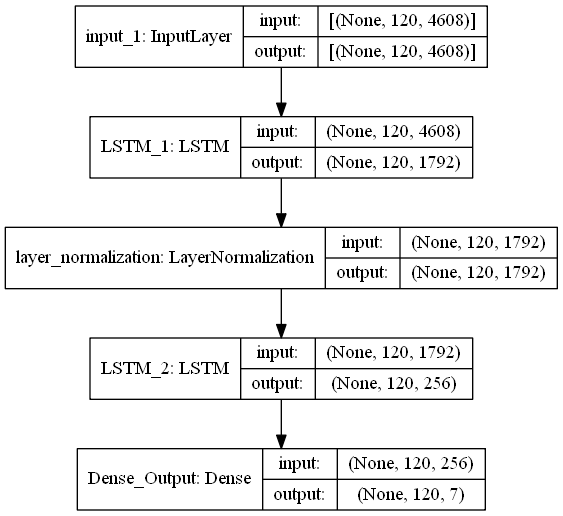

In [19]:
# Plot CNN-LSTM model
tf.keras.utils.plot_model(
    LSTM,
    to_file="images/models/LSTM_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Plot performance of model

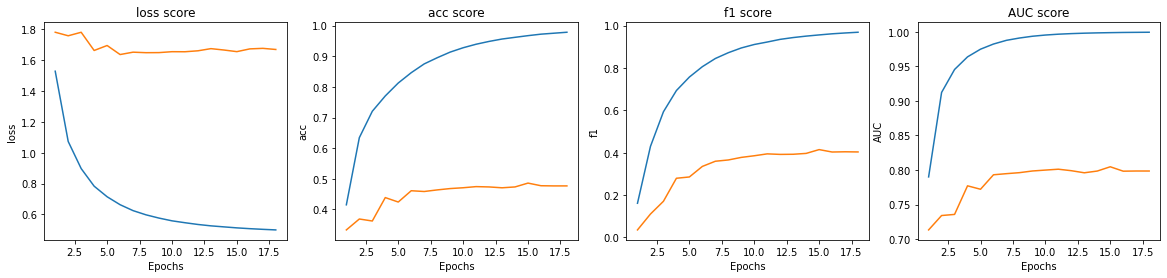

In [20]:
model_hist = history_best.history

labels = [*model_hist.keys()]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
epochs = range(1, len(model_hist["loss"]) + 1)
for data, label in zip(
    [model_hist["loss"], model_hist["val_loss"]], [labels[0], labels[4]]
):
    axes[0].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["accuracy"], model_hist["val_accuracy"]], [labels[1], labels[5]]
):
    axes[1].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["f1"], model_hist["val_f1"]], [labels[2], labels[6]]
):
    axes[2].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["auc"], model_hist["val_auc"]], [labels[3], labels[7]]
):
    axes[3].plot(epochs, data, label=label)

for i, label in zip(range(4), ["loss", "acc", "f1", "AUC"]):
    axes[i].set_title(label + " score")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(label)

In [22]:
# Save model performance to json file
with open("data/models/LSTM_performance.json", "w") as fp:
    json.dump(model_hist, fp)

## Save model+weights to folder

In [21]:
# Save model
tf.keras.Model.save(LSTM, filepath="data/models/LSTM_model.h5")

## Calculate precision score with SKlearnbest_LSTM

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

In [ ]:
# Do predictions on test set
val_predv2 = v2.predict(seq_val_features, verbose=0)

# Reshape back to (frame, label)
val_predv2 = np.reshape(
    val_predv2, (val_predv2.shape[0] * val_predv2.shape[1], val_predv2.shape[2])
)

# Convert one hot encoding to integers
val_predv2 = np.argmax(val_predv2, axis=1)

In [ ]:
# Reshape back to (frame, label)
val_true = np.reshape(
    seq_val_labels,
    (seq_val_labels.shape[0] * seq_val_labels.shape[1], seq_val_labels.shape[2]),
)
val_true = np.argmax(val_true, axis=1)

In [ ]:
# F1 Results with model v3
for avg in [None, "micro", "macro", "weighted"]:
    score = f1_score(val_true, val_predv3, average=avg)
    print(f"Average method: {avg}, f1-score: {score}")